In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Project_1B_Left_ventricle_segmentation_using_Differential_Programming/code/EDPCNN-master

In [ ]:
!ls

acdc			evaluate_unet.py  our_train_unet.py  train_edpcnn.py
_config.yml		imgs		  __pycache__	     train_unet.py
data_iterator.py	log		  README.md	     utils.py
demo1_LV_Segment.ipynb	losses.py	  run_edpcnn.py      visualize
demo.ipynb		metrics_acdc.py   run_unet.py
evaluate_edpcnn.py	network.py	  snake
evaluate_unet+dp.py	our_run_unet.py   sys_config.py


# **Installing Necessary Libraries**

In [ ]:
!pip install numpy

In [ ]:
import torch
print(torch.__version__)

1.9.0+cu102


In [ ]:
!pip install TensorboardX

In [ ]:
!pip install shapely

In [ ]:
!pip install scipy

In [ ]:
!pip install scikit-image

In [ ]:
!pip install nibabel

In [ ]:
!pip install h5py

In [ ]:
!pip install pytorch-warmup

In [ ]:
!pip install warmup-scheduler

# **Data Exploration**

In [ ]:
import h5py as hp

In [ ]:
data = hp.File("/content/drive/MyDrive/Project_1B_Left_ventricle_segmentation_using_Differential_Programming/Dataset/data_2D_size_212_212_res_1.36719_1.36719.hdf5")

In [ ]:
list(data.keys())

['cardiac_phase_test',
 'cardiac_phase_train',
 'diagnosis_test',
 'diagnosis_train',
 'height_test',
 'height_train',
 'images_test',
 'images_train',
 'masks_test',
 'masks_train',
 'patient_id_test',
 'patient_id_train',
 'weight_test',
 'weight_train']

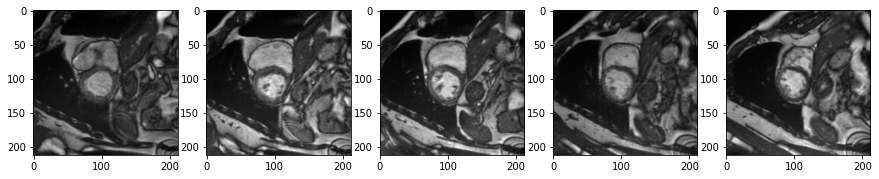

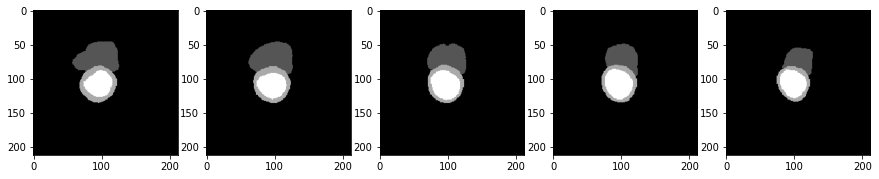

In [ ]:
# Visualizing the train data set

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  img = data["images_train"][j].squeeze()
  fig1.add_subplot(1, 5, j+1)
  plt.imshow(img, cmap=plt.cm.gray)

plt.savefig("visualize/train_images_dummy.jpg")
fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  mask = data["masks_train"][j]
  fig2.add_subplot(1, 5, j+1)
  plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)

plt.savefig("visualize/train_masks_duummy.jpg")

plt.show()

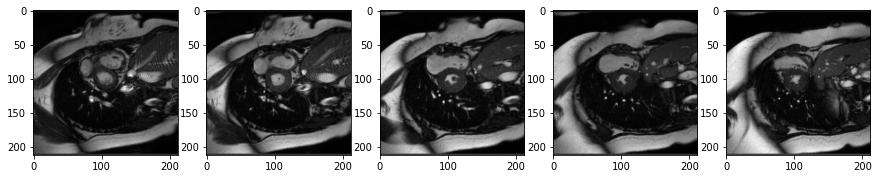

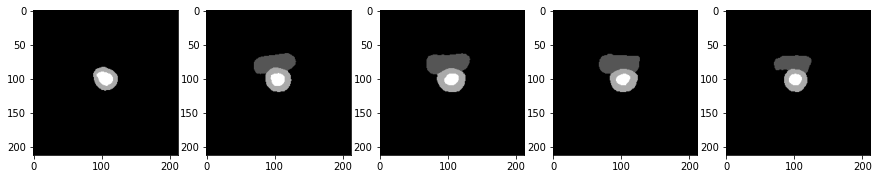

In [ ]:
# Visualizing the test data set

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  img = data["images_test"][j].squeeze()
  fig1.add_subplot(1, 5, j+1)
  plt.imshow(img, cmap=plt.cm.gray)

plt.savefig("visualize/test_images_dummy.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
  mask = data["masks_test"][j]
  fig2.add_subplot(1, 5, j+1)
  plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)

plt.savefig("visualize/test_masks_dummy.jpg")

plt.show()

In [ ]:
# description of train and test data

train_imgs = data["images_train"]; train_masks = data["masks_train"]
test_imgs = data["images_test"]; test_masks = data["masks_test"]

print("Train images : ", train_imgs.shape)
print("Train masks : ", train_masks.shape)
print("Test images : ", test_imgs.shape)
print("Test masks : ", test_masks.shape)
print("Diagnosis train : ", data["diagnosis_train"].shape)
print("Patient id train : ", data["patient_id_train"].shape)

Train images :  (1516, 212, 212)
Train masks :  (1516, 212, 212)
Test images :  (386, 212, 212)
Test masks :  (386, 212, 212)
Diagnosis train :  (160,)
Patient id train :  (160,)


In [ ]:
import pandas as pd
pd.Series(data["diagnosis_train"]).unique()

array([0, 4, 3, 2, 1], dtype=uint8)

As we are segmenting the left ventricle only, so converting the masks into left ventricle masks....

In [ ]:
import numpy as np
from data_iterator import one_hot_encode

one_hot_masks = one_hot_encode(np.asarray(train_masks))

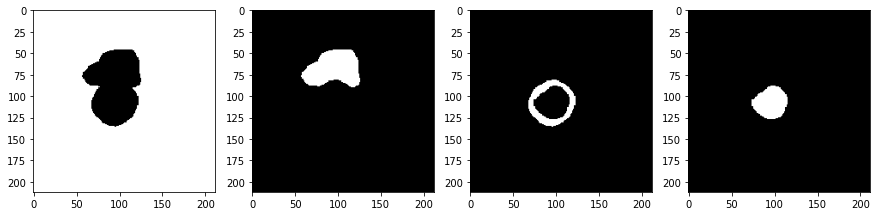

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.figure(figsize = (15,15))
for i in range(4):
  fig.add_subplot(1, 4, i+1)
  plt.imshow(one_hot_masks[0][:,:,i],'gray')

plt.show()

plt.savefig("visualize/one_hot_mask.jpg")

In [ ]:
# Comparing the area of Left ventricle with respect to Diseases.

from skimage.measure import label, regionprops, regionprops_table

lvlist0 = []
lvlist1 = []
lvlist2 = []
lvlist3 = []
lvlist4 = []

for i,diag in enumerate(data["diagnosis_train"]):
  if diag == 0:
    label_img = label(one_hot_masks[i])
    regions = regionprops(label_img)
    for prop in regions:
      lvlist0.append(prop.area)

  if diag == 1:
    label_img = label(one_hot_masks[i])
    regions = regionprops(label_img)
    for prop in regions:
      lvlist1.append(prop.area)

  if diag == 2:
    label_img = label(one_hot_masks[i])
    regions = regionprops(label_img)
    for prop in regions:
      lvlist2.append(prop.area)

  if diag == 3:
    label_img = label(one_hot_masks[i])
    regions = regionprops(label_img)
    for prop in regions:
      lvlist3.append(prop.area)

  if diag == 4:
    label_img = label(one_hot_masks[i])
    regions = regionprops(label_img)
    for prop in regions:
      lvlist4.append(prop.area)

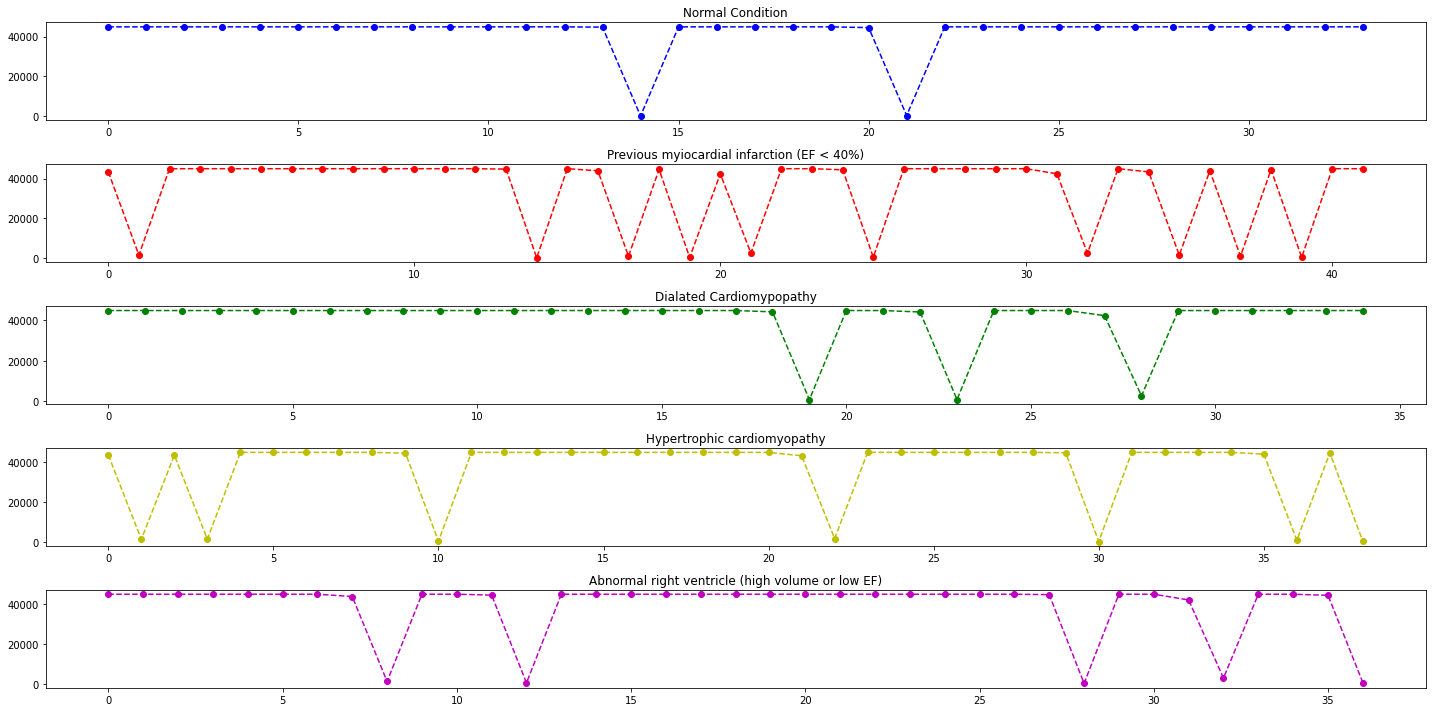

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(511)
plt.plot(lvlist0,'ob--')
plt.title("Normal Condition")
plt.subplot(512)
plt.plot(lvlist1,'or--')
plt.title("Previous myiocardial infarction (EF < 40%)")
plt.subplot(513)
plt.plot(lvlist2,'og--')
plt.title("Dialated Cardiomypopathy")
plt.subplot(514)
plt.plot(lvlist3,'oy--')
plt.title("Hypertrophic cardiomyopathy")
plt.subplot(515)
plt.plot(lvlist4,'om--')
plt.title("Abnormal right ventricle (high volume or low EF)")

plt.tight_layout()

plt.savefig("visualize/area_vs_diag.jpg")

Anyway, all of these has been done inside the data_iterator...

# **The Dataloader object**

In [ ]:
from data_iterator import Dataset

d = Dataset()

/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/data_2D_size_212_212_res_1.36719_1.36719.hdf5
Keys in dataset:  ['cardiac_phase_test', 'cardiac_phase_train', 'diagnosis_test', 'diagnosis_train', 'height_test', 'height_train', 'images_test', 'images_train', 'masks_test', 'masks_train', 'patient_id_test', 'patient_id_train', 'weight_test', 'weight_train']


/usr/local/lib/python3.8/dist-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [ ]:
train = d.train_set; test = d.test_set

In [ ]:
print(train.dataset_sz())
print(train.unet_centers)
print(train.batch_ptr)
imgs, masks, one_hot_masks, centers, dts_modified, dts_original, jitter_radius, bboxes = train.next_batch(10)
print(train.batch_ptr)

1436
None
10
20


In [ ]:
print(train.images.shape)
print(one_hot_masks.shape)
print(dts_modified.shape)
print(dts_original.shape)
print(jitter_radius.shape)
print(bboxes.shape)

(1516, 1, 212, 212)
(10, 2, 212, 212)
(10, 1, 212, 212)
(10, 1, 212, 212)
(10,)
(10, 4)


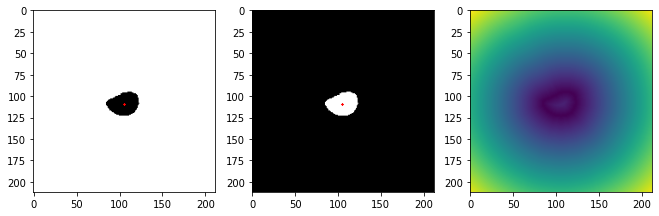

<Figure size 432x288 with 0 Axes>

In [ ]:
#one_hot_masks and dts

fig = plt.figure(figsize = (15,15))
for i in range(2):
  fig.add_subplot(1, 4, i+1)
  plt.imshow(one_hot_masks[0].transpose([1,2,0])[:,:,i],'gray')
  plt.scatter(centers[0][1], centers[0][0], color="r", marker="x", s=2)

fig.add_subplot(1,4,3)
plt.imshow(dts_modified[0].transpose([1,2,0])[:,:,0])

plt.show()

plt.savefig("visualize/data_iters.jpg")

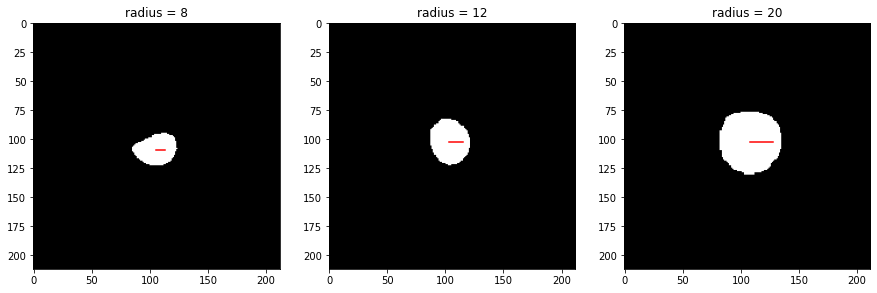

<Figure size 432x288 with 0 Axes>

In [ ]:
# radius of left ventricle region

fig = plt.figure(figsize = (15,15))
for i in range(3):
  fig.add_subplot(1, 3, i+1)
  plt.imshow(one_hot_masks[i].transpose([1,2,0])[:,:,1],'gray')
  plt.plot([centers[i][1], centers[i][1]+jitter_radius[i]], [centers[i][0], centers[i][0]], 'r-')
  plt.title("radius = {}".format(jitter_radius[i]))

plt.show()

plt.savefig("visualize/radius.jpg")

# **Training the U-Net**

In [ ]:
!ls

acdc			    log			 run_unet.py
_config.yml		    losses.py		 snake
data_iterator.py	    metrics_acdc.py	 sys_config.py
demo_EDPCNN.ipynb	    network.py		 train_edpcnn.py
demo.ipynb		    our_run_unet.py	 train_unet.py
demo_UNet_LV_Segment.ipynb  our_train_edpcnn.py  Unet_predictions
evaluate_edpcnn.py	    our_train_unet.py	 utils.py
evaluate_unet+dp.py	    __pycache__		 visualize
evaluate_unet.py	    README.md
imgs			    run_edpcnn.py


In [ ]:
from our_train_unet import main as train_unet
import pandas as pd
import numpy as np

In [ ]:
args = pd.Series({'seed': 0,
                 'lr': 1e-4,
                 'n_epochs': 500,
                 'weight_decay': 0.0,
                 'batch_sz': 10,
                 'log_freq': 50,
                 'train_eval_freq': 50,
                 'val_eval_freq': 50,
                 'train_set_sz': 1516,
                 'num_cls': 1,
                 'log_dir': 'log/unet-1_cls/ours',
                 'load_pretrained':0,
                 'use_ce': 1})

In [ ]:
args.n_epochs

500

In [ ]:
out = train_unet(args)

In [ ]:
## Loss evolution during training
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
plt.plot(out[2],'b')
plt.xlabel("no of epochs")
plt.ylabel("cross-entropy loss")
plt.title("Loss evolution")

plt.savefig("/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/EDPCNN-master/visualize/loss.jpg")

In [ ]:
## Dice Scores (for train and validation data)
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
plt.plot(out[3],'b')
plt.plot(out[4],'r')
plt.legend(["Train dice score", "test dice score"])
plt.title("Dice Score Comparison")

plt.savefig("/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/EDPCNN-master/visualize/dices.jpg")

# **Evaluation for Unet**

In [ ]:
from network import UNet
import _pickle
import torch
from utils import one_hot_embedding_pytorch
from our_train_unet import make_batch_input
import torch.nn.functional as F

In [ ]:
net = UNet(in_dim=1, out_dim=2)#.cuda()
ckpt_path = "/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/EDPCNN-master/log/unet-1_cls/ours/best_model.pth.tar"
net.load_state_dict(_pickle.load(open(ckpt_path, 'rb')))

/home/sysadm/Dipan/LV_Seg/EDPCNN-master-20210621T060724Z-001/EDPCNN-master/network.py:11: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


<All keys matched successfully>

In [ ]:
#preparing the predictions

imgs = test.images
batch_sz = 10
num_classes = 2

l_pred =[]

net.eval()
with torch.no_grad():
    data_sz = len(imgs)
    n_batches = int(np.ceil(data_sz / batch_sz))
    dice_scores = []
    for j in range(n_batches):
        start = j * batch_sz
        end = (j + 1) * batch_sz
        imgs_batch = imgs[start:end]
        imgs_batch = make_batch_input(imgs_batch)
        imgs_batch = torch.cuda.FloatTensor(imgs_batch)
        logits = net(imgs_batch)
        softmax = F.softmax(logits, dim=1)
        pred_class = torch.argmax(softmax, dim=1)
        for i in range(len(pred_class)):
            pred = pred_class[i].cpu().numpy()
            l_pred.append(pred)

/home/sysadm/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


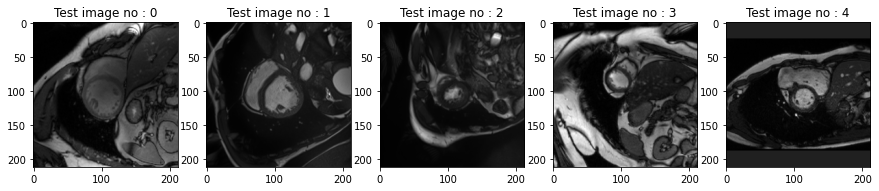

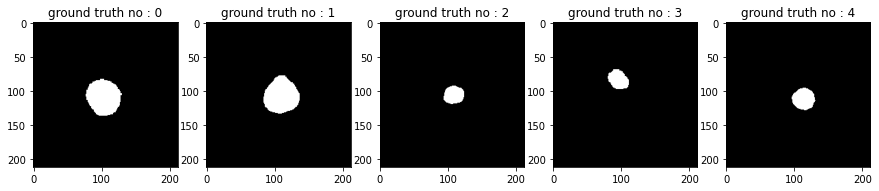

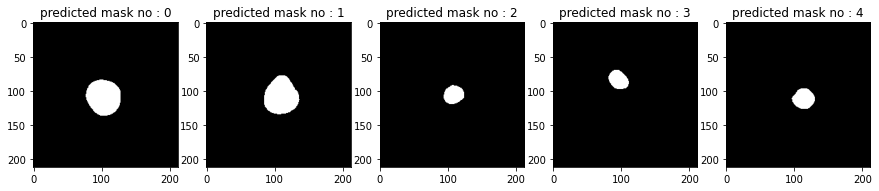

In [ ]:
# Visualizing the predictions for test data set

import matplotlib.pyplot as plt

fig1 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    img = test.images[j].squeeze()
    fig1.add_subplot(1, 5, j+1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Test image no : "+str(j))

plt.savefig("visualize/test_images.jpg")

fig2 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    mask = test.masks[j]
    fig2.add_subplot(1, 5, j+1)
    plt.imshow(mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title('ground truth no : '+str(j))

plt.savefig("visualize/test_masks.jpg")

fig3 = plt.figure(figsize = (15,15))
for j in range(0,5,1):
    pred_mask = l_pred[j]
    fig3.add_subplot(1, 5, j+1)
    plt.imshow(pred_mask, alpha=1.0, cmap=plt.cm.gray)
    plt.title("predicted mask no : "+str(j))

plt.savefig("visualize/predicted_masks.jpg")    
    
plt.show()

In [ ]:
## saving the predictions

from PIL import Image

for i,img in enumerate(l_pred):
    im = Image.fromarray((l_pred[i] * 255).astype(np.uint8))
    im.save("Unet_predictions/pred_mask{:03d}".format(i)+".jpg")